# クラス分類学習モデルの作成、予測の実行

In [58]:
import os
import random

# basic DS libraries
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# plot libraries
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

%matplotlib inline

# プログレスバー
from tqdm import tqdm

# from sklearn.decomposition import PCA  # 主成分分析

# 機械学習モデル
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析

# データセット分割・評価検証
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# config python file
import config

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

# ファイル保存関数（dirがなければ生成する）
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


# seedの固定
def fix_seed(seed: int):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)


# 再現性をもたせるためのseed固定
SEED = config.SEED
fix_seed(SEED)

# 2値分類モデルの作成・実行

2値分類モデルを作成、実行し、クラス分類に有用な特徴量を見つける  
決定木以外にも、基本的な2値分類を実施できるモデルを採用し、各モデル間で比較していく。  
精度は重視しないが、accuracyよりもf1スコアを重視する。  
目的変数に偏りがある（不均衡データ、1（5年後以内に死亡）<0（5年語以内に生存））ので、**サンプリング方法を要検討**

In [33]:
df_MB_OS_status_in_5years_dropped = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_DIR
    + "/2.0.4-df_MB_OS_status_in_5years_dropped.pkl"
)
df_MB_OS_status_in_5years_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1042 entries, 0 to 1123
Data columns (total 56 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   LYMPH_NODES_EXAMINED_POSITIVE                                   1042 non-null   float64
 1   NPI                                                             1042 non-null   float64
 2   CELLULARITY                                                     1042 non-null   int64  
 3   CHEMOTHERAPY                                                    1042 non-null   bool   
 4   ER_IHC                                                          1042 non-null   int64  
 5   HER2_SNP6                                                       1042 non-null   int64  
 6   HORMONE_THERAPY                                                 1042 non-null   bool   
 7   INFERRED_MENOPAUSAL_STATE                          

In [34]:
print(df_MB_OS_status_in_5years_dropped.target.value_counts())

print(
    "データセット全体に占める5年後の死亡者のデータの割合： ",
    df_MB_OS_status_in_5years_dropped[
        df_MB_OS_status_in_5years_dropped.target == True
    ].shape[0]
    / df_MB_OS_status_in_5years_dropped.shape[0],
)

False    844
True     198
Name: target, dtype: int64
データセット全体に占める5年後の死亡者のデータの割合：  0.19001919385796545


# 学習データ分割

1. X（説明変数）とy（目的変数）に分割(y=df['target'])
2. train_test_splitによる基本的なデータ分割（train:test=75%:25%）※層化検証など他の分割手法は後で実施  

In [35]:
# Xとyに分割
X = df_MB_OS_status_in_5years_dropped.drop("target", axis=1)
y = df_MB_OS_status_in_5years_dropped["target"]
display(X.tail(), y.tail(), y.value_counts())

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,ER_IHC,HER2_SNP6,HORMONE_THERAPY,INFERRED_MENOPAUSAL_STATE,AGE_AT_DIAGNOSIS,RADIO_THERAPY,ER_STATUS,HER2_STATUS,GRADE,PR_STATUS,TUMOR_SIZE,TUMOR_STAGE,TMB_NONSYNONYMOUS,COHORT_2.0,COHORT_3.0,COHORT_5.0,INTCLUST_10,INTCLUST_2,INTCLUST_3,INTCLUST_4ER+,INTCLUST_4ER-,...,CLAUDIN_SUBTYPE_Her2,CLAUDIN_SUBTYPE_LumA,CLAUDIN_SUBTYPE_LumB,CLAUDIN_SUBTYPE_NC,CLAUDIN_SUBTYPE_Normal,CLAUDIN_SUBTYPE_claudin-low,THREEGENE_ER+/HER2- Low Prolif,THREEGENE_ER-/HER2-,THREEGENE_HER2+,HISTOLOGICAL_SUBTYPE_Lobular,HISTOLOGICAL_SUBTYPE_Medullary,HISTOLOGICAL_SUBTYPE_Mixed,HISTOLOGICAL_SUBTYPE_Mucinous,HISTOLOGICAL_SUBTYPE_Other,HISTOLOGICAL_SUBTYPE_Tubular/ cribriform,BREAST_SURGERY_MASTECTOMY,LATERALITY_Right,CANCER_TYPE_DETAILED_Breast Invasive Ductal Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Lobular Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Mixed Mucinous Carcinoma,CANCER_TYPE_DETAILED_Breast Mixed Ductal and Lobular Carcinoma,ONCOTREE_CODE_IDC,ONCOTREE_CODE_ILC,ONCOTREE_CODE_IMMC,ONCOTREE_CODE_MDLC
1119,4.0,5.060,3,False,1,2,True,1,71.22,False,1,-1,2.0,1,30.0,2.0,14.382695,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1120,0.0,2.040,3,False,1,2,False,1,70.65,True,1,-1,1.0,1,20.0,1.0,11.767659,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1121,0.0,4.040,3,False,-1,3,False,1,75.62,False,-1,-1,3.0,-1,20.0,1.0,5.230071,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1122,6.0,5.040,3,True,1,2,False,1,52.84,True,1,-1,2.0,1,20.0,2.0,6.537589,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1123,0.0,3.044,3,False,1,2,False,1,63.20,True,1,-1,2.0,1,22.0,2.0,3.922553,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


1119    False
1120    False
1121    False
1122    False
1123    False
Name: target, dtype: bool

False    844
True     198
Name: target, dtype: int64

In [36]:
# trainとtestに分割

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.SEED)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
display(y_train.value_counts(), y_test.value_counts())

(781, 55)

(261, 55)

(781,)

(261,)

False    638
True     143
Name: target, dtype: int64

False    206
True      55
Name: target, dtype: int64

学習データの分布をプロット

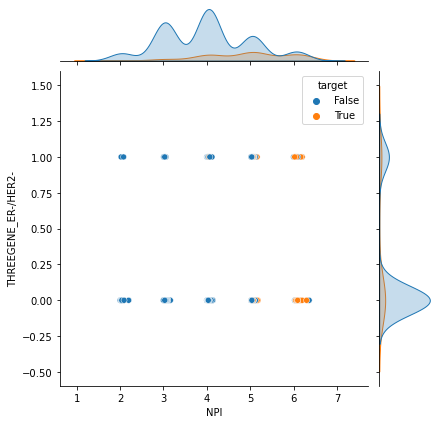

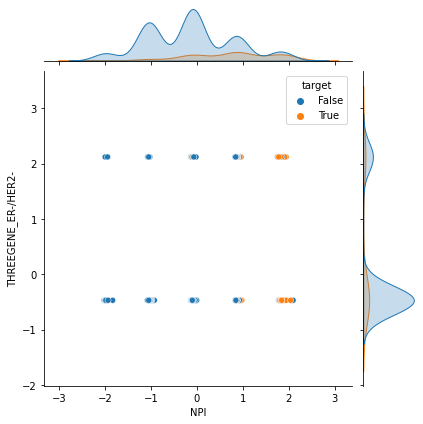

In [115]:
# 決定木モデルで上位に来た重要度の特徴量
plot_columns = ["NPI", "THREEGENE_ER-/HER2-"]
sns.jointplot(
    x=plot_columns[0],
    y=plot_columns[1],
    data=pd.merge(X_train, y_train, left_index=True, right_index=True),
    hue="target",
)
plt.show()

# x,y軸の特徴量の標準化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_tmp = pd.merge(X_train, y_train, left_index=True, right_index=True)
scaler.fit(df_tmp[plot_columns])
df_tmp[plot_columns] = pd.DataFrame(
    scaler.transform(df_tmp[plot_columns]),
    index=df_tmp.index,
    columns=plot_columns,
)

sns.jointplot(
    x=plot_columns[0],
    y=plot_columns[1],
    data=df_tmp,
    hue="target",
)
plt.show()

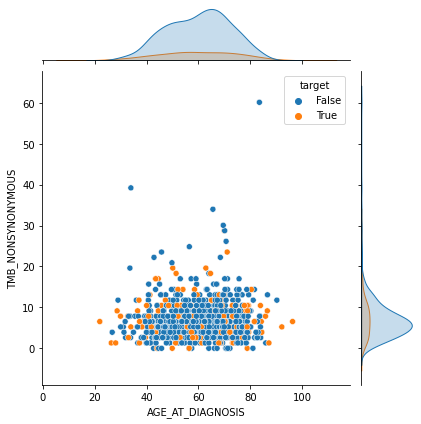

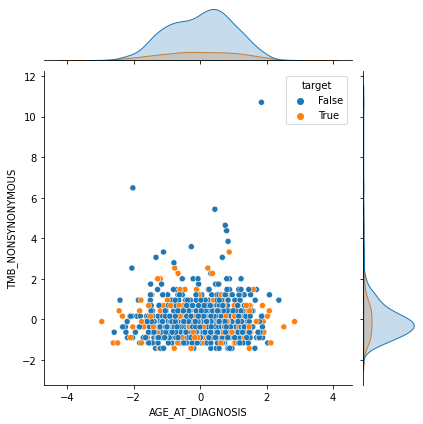

In [117]:
# 適当な分散のある特徴量
plot_columns = ["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"]
sns.jointplot(
    x=plot_columns[0],
    y=plot_columns[1],
    data=pd.merge(X_train, y_train, left_index=True, right_index=True),
    hue="target",
)
plt.show()

# x,y軸の特徴量の標準化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_tmp = pd.merge(X_train, y_train, left_index=True, right_index=True)
scaler.fit(df_tmp[plot_columns])
df_tmp[plot_columns] = pd.DataFrame(
    scaler.transform(df_tmp[plot_columns]),
    index=df_tmp.index,
    columns=plot_columns,
)

sns.jointplot(
    x=plot_columns[0],
    y=plot_columns[1],
    data=df_tmp,
    hue="target",
)
plt.show()

# SMOTEによるオーバーサンプリング
SMOTEと呼ばれる手法によって、不均衡を低減する  
どのようにオーバーサンプリングするのか要確認

In [110]:
sm = SMOTE(random_state=SEED)

X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
y_resampled.value_counts()

True     638
False    638
Name: target, dtype: int64

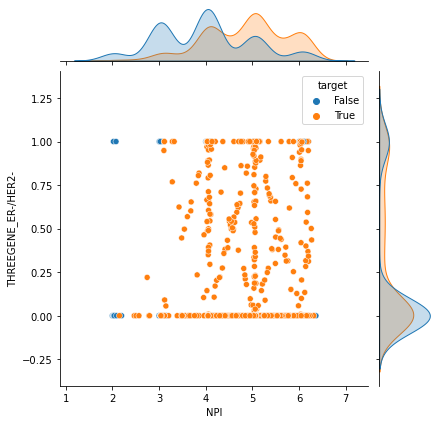

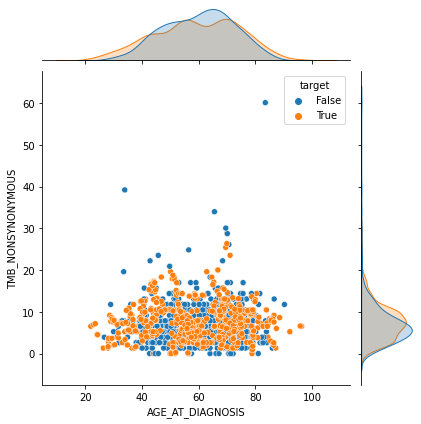

In [113]:
# オーバーサンプリング結果のプロット
plot_columns = ["NPI", "THREEGENE_ER-/HER2-"]

sns.jointplot(
    x="NPI",
    y="THREEGENE_ER-/HER2-",
    data=pd.merge(X_resampled, y_resampled, left_index=True, right_index=True),
    hue="target",
)
plt.show()

plot_columns = ["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"]
sns.jointplot(
    x=plot_columns[0],
    y=plot_columns[1],
    data=pd.merge(X_resampled, y_resampled, left_index=True, right_index=True),
    hue="target",
)
plt.show()

# 2値分類モデル

In [38]:
def show_scores(y_test: pd.Series, y_pred_tree: pd.Series):
    print("accuracy: ", accuracy_score(y_test, y_pred_tree))
    print("precision: ", precision_score(y_test, y_pred_tree))
    print("recall: ", recall_score(y_test, y_pred_tree))
    print("f1 score: ", f1_score(y_test, y_pred_tree))

In [39]:
def show_confusion_matrix(
    y_test: pd.Series,
    y_pred: pd.Series,
    model_name: str = "confusion matrix",
    display_details: bool = False,
):
    cm = confusion_matrix(y_test, y_pred, normalize="all", labels=[True, False])
    df_cm = pd.DataFrame(data=cm, index=[True, False], columns=[True, False])

    fig = plt.figure()
    sns.heatmap(df_cm, square=True, cbar=True, annot=True, cmap="Blues")
    plt.title(model_name)
    plt.xlabel("Predict label")
    plt.ylabel("True label")
    plt.plot()

    if display_details:
        tn, fp, fn, tp = cm.ravel()
        print("tn: ", tn, "\nfp: ", fp, "\nfn:", fn, "\ntp:", tp)
        show_scores(y_test, y_pred)

## ベースラインの精度

全てFalseと予測（学習データはFalseが多いため）した場合のスコア

False    206
True      55
Name: target, dtype: int64

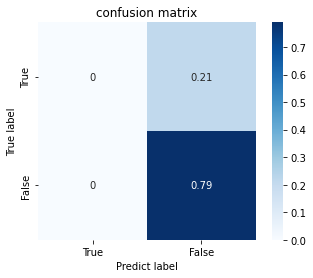

In [40]:
y_base = pd.Series([False for i in range(y_test.shape[0])], index=y_test.index)
display(y_test.value_counts())
show_confusion_matrix(y_test, y_base)

# 様々な機械学習手法の比較

様々な機械学習手法を用いて2値分類を行う。  
簡単に精度を見るため、再現性は担保されていない（引数にrandom_stateを要求しないclfもあるため）ので、必要に応じて再度モデルを構築すること。  
また、パラメータはデフォルト値を使用している。  
そのためパラメータ次第では結果が向上、下降しうる（決定木のf1など）。  

In [41]:
bcm_names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "Polynomial SVM",
    "RBF SVM",
    "Sigmoid SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    # "Linear Discriminant Analysis", # predictメソッドに対応していない
    "Quadratic Discriminant Analysis",
]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="poly"),
    SVC(kernel="rbf"),
    SVC(kernel="sigmoid"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    # LDA(),
    QDA(),
]

In [62]:
import warnings


def compare_bcms(
    bcm_names: list = bcm_names,
    classifiers: list = classifiers,
    sort_column_name: str = "f1_test",
    average_time: int = 20,
    test_size: float = 0.25,
):
    warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示
    sm = SMOTE()
    result = []

    for trial in tqdm(range(average_time)):  # average_time 回繰り返し、指標の平均を見る
        # 乱数の影響を均した平均を取りたいので、SEEDは保留。乱数に依存しない精度を見るので再現性は'ここでは'担保しない。
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size
        )  # 訓練データ・テストデータの生成
        if sm:
            X_train, y_train = sm.fit_resample(X_train, y_train)

        for name, clf in zip(bcm_names, classifiers):  # 指定した複数の分類機を順番に呼び出す
            # 訓練のスコア
            clf.fit(X_train, y_train)  # 学習
            y_pred_train = clf.predict(X_train)
            acc_train = accuracy_score(y_train, y_pred_train)
            f1_train = f1_score(y_train, y_pred_train)
            # 　予測値のスコア
            y_pred = clf.predict(X_test)
            acc_test = accuracy_score(y_test, y_pred)  # 正解率（test）の算出
            f1_test = f1_score(y_test, y_pred)
            result.append([name, acc_train, acc_test, f1_train, f1_test])  # 結果の格納

    # 表示設定
    df_result = pd.DataFrame(
        result, columns=["classifier", "acc_train", "acc_test", "f1_train", "f1_test"]
    )
    df_result_mean = (
        df_result.groupby("classifier")
        .mean()
        .sort_values(sort_column_name, ascending=False)
    )
    warnings.filterwarnings("always")
    return df_result_mean

数回実行し、再現性がないことと、各モデルが頑健かの確認

In [63]:
compare_bcms()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.44s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
RBF SVM,0.722268,0.726437,0.715353,0.475364
Logistic Regression,0.789264,0.735441,0.791052,0.459290
Linear SVM,0.794346,0.729119,0.796870,0.449441
Polynomial SVM,0.678582,0.760728,0.622483,0.441992
Nearest Neighbors,0.873602,0.662644,0.886338,0.403106
AdaBoost,0.890322,0.785441,0.887865,0.392369
Naive Bayes,0.618300,0.381801,0.717082,0.351242
Random Forest,1.000000,0.806322,1.000000,0.335721
Decision Tree,1.000000,0.730268,1.000000,0.330923


## 決定木モデルの構築・検証

決定木モデルを構築し、検証していく。  
パラメータを操作するため、forループで回し、最もスコアの高いものを見ていく。

In [64]:
compare_bcms()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
RBF SVM,0.718972,0.727011,0.710655,0.471547
Logistic Regression,0.792354,0.731609,0.794901,0.436966
Linear SVM,0.799387,0.730843,0.801733,0.433410
Polynomial SVM,0.684364,0.753831,0.632106,0.427275
Nearest Neighbors,0.873278,0.669540,0.886030,0.402892
AdaBoost,0.889256,0.783525,0.886828,0.382167
Decision Tree,1.000000,0.742529,1.000000,0.355413
Naive Bayes,0.629410,0.395019,0.722752,0.346609
Random Forest,1.000000,0.807471,1.000000,0.325927


In [45]:
import warnings

warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示

accuracies_tree = {}
precisions_tree = {}
recalls_tree = {}
f1_scores_tree = {}

for nodes_num in range(2, 50):
    clf_tree = DecisionTreeClassifier(
        max_leaf_nodes=nodes_num, random_state=config.SEED
    )
    clf_tree = clf_tree.fit(X_resampled, y_resampled)

    y_pred_tree = clf_tree.predict(X_test)

    accuracies_tree[nodes_num] = accuracy_score(y_test, y_pred_tree)
    precisions_tree[nodes_num] = precision_score(y_test, y_pred_tree)
    recalls_tree[nodes_num] = recall_score(y_test, y_pred_tree)
    f1_scores_tree[nodes_num] = f1_score(y_test, y_pred_tree)

    print("nodes_num: ", nodes_num)
    show_scores(y_test, y_pred_tree)
    print("----------" * 10)

warnings.filterwarnings("always")

nodes_num:  2
accuracy:  0.735632183908046
precision:  0.4166666666666667
recall:  0.6363636363636364
f1 score:  0.5035971223021583
----------------------------------------------------------------------------------------------------
nodes_num:  3
accuracy:  0.7777777777777778
precision:  0.47619047619047616
recall:  0.5454545454545454
f1 score:  0.5084745762711864
----------------------------------------------------------------------------------------------------
nodes_num:  4
accuracy:  0.7011494252873564
precision:  0.37362637362637363
recall:  0.6181818181818182
f1 score:  0.4657534246575342
----------------------------------------------------------------------------------------------------
nodes_num:  5
accuracy:  0.7777777777777778
precision:  0.47619047619047616
recall:  0.5454545454545454
f1 score:  0.5084745762711864
----------------------------------------------------------------------------------------------------
nodes_num:  6
accuracy:  0.7777777777777778
precision:  0.4594

In [65]:
compare_bcms()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.40s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
RBF SVM,0.718535,0.724904,0.708776,0.471063
Logistic Regression,0.791358,0.724904,0.793165,0.437915
Polynomial SVM,0.680198,0.754789,0.624843,0.434460
Linear SVM,0.796380,0.719349,0.798595,0.433801
Nearest Neighbors,0.873329,0.662452,0.886103,0.400272
AdaBoost,0.888341,0.779119,0.885916,0.371882
Decision Tree,1.000000,0.746360,1.000000,0.358696
Naive Bayes,0.636487,0.415709,0.725132,0.355879
Random Forest,1.000000,0.803257,1.000000,0.336636


'max nodes_num'

19

19

2

3

accuracy:  0.7777777777777778
precision:  0.47619047619047616
recall:  0.5454545454545454
f1_score:  0.5084745762711864


Text(0, 0.5, 'score')

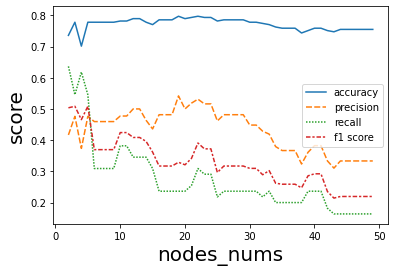

In [46]:
# 各スコアのプロット
display(
    "max nodes_num",
    max(accuracies_tree, key=accuracies_tree.get),
    max(precisions_tree, key=precisions_tree.get),
    max(recalls_tree, key=recalls_tree.get),
    max(f1_scores_tree, key=f1_scores_tree.get),
)

# f1_scoreが最も高いモデルのスコア
print(
    "accuracy: ",
    accuracies_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "precision: ",
    precisions_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "recall: ",
    recalls_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "f1_score: ",
    f1_scores_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)

df_score_tree = pd.DataFrame(
    [accuracies_tree, precisions_tree, recalls_tree, f1_scores_tree],
    index=["accuracy", "precision", "recall", "f1 score"],
    columns=accuracies_tree.keys(),
).T
p = sns.lineplot(data=df_score_tree)
p.set_xlabel("nodes_nums", fontsize=20)
p.set_ylabel("score", fontsize=20)

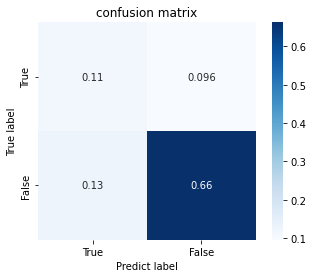

In [47]:
clf_tree = DecisionTreeClassifier(
    max_leaf_nodes=max(f1_scores_tree, key=f1_scores_tree.get),
    random_state=config.SEED,
)
clf_tree = clf_tree.fit(X_resampled, y_resampled)
y_pred_tree = clf_tree.predict(X_test)
show_confusion_matrix(y_test, y_pred_tree)